In [1]:
import sys
import os
import matplotlib.pyplot as plt
import torch
# Add the src directory to the path. TEMPORARY FIX
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../..")))

from models.deeplab.deeplab import DeepLabV3
from src.models.data_management.cnn_formes import CNNFormes
from src.data_processing.dataset_loader import CoastData
from src.models.metrics import Metrics

from src.models.data_management.data_loader import DataLoaderManager

import cv2

In [2]:
artifact_path = os.path.abspath(os.path.join(os.getcwd(), "../../../artifacts/"))

num_classes = 3
metrics = {
    "train": Metrics(phase="train", num_classes=num_classes, average=None, use_margin=False),
    "validation": Metrics(phase="val", num_classes=num_classes, average=None, use_margin=False),
    "test": Metrics(phase="test", num_classes=num_classes, average=None, use_margin=False) # 'macro'
}

# Load the data to split it and save it to a dict
model  = DeepLabV3(num_classes=3, experiment_name="test_experiments", use_mlflow=False, pretrained=False)

model.load_model(os.path.abspath(os.path.join(artifact_path, "2025-03-12-11-44-51_deeplab/models/best_model.pth")))

data_path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/processed"))

coast_data = CoastData(data_path)
split = coast_data.split_data()

data = DataLoaderManager.load_data(split)

Using cache found in C:\Users\josep/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\josep\.conda\envs\imagine\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\josep\.conda\envs\imagine\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\josep/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%


CoastData: global - 1717 images
Coast: agrelo, Total size: 244
Coast: arenaldentem, Total size: 40
Coast: cadiz, Total size: 946
Coast: cies, Total size: 430
Coast: samarador, Total size: 57


In [5]:
for split in data:
    print(f"Split: {split}")
    for img_path, mask_path in zip(data[split]["images"], data[split]["masks"]):
        pred = model.predict_patch(img_path, combination="max")
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = torch.from_numpy(mask).float() 
        metrics[split].update_metrics(pred, mask)

    metrics[split].compute()
    print(metrics[split].get_last_epoch_info())

Split: train


/opt/conda/lib/python3.10/site-packages/torcheval/metrics/functional/classification/accuracy.py:275: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:230.)
  num_correct = mask.new_zeros(num_classes).scatter_(0, target, mask, reduce="add")


train metrics: 
	train_accuracy: tensor([0.9980, 0.9849, 0.9887])
	train_f1_score: tensor([0.9932, 0.9886, 0.9886])
	train_precision: tensor([0.9884, 0.9924, 0.9885])
	train_recall: tensor([0.9980, 0.9849, 0.9887])
	train_confusion_matrix: 
		0.9980 0.0007 0.0013
		0.0048 0.9849 0.0103
		0.0041 0.0072 0.9887

Split: validation
val metrics: 
	val_accuracy: tensor([0.9989, 0.9798, 0.9816])
	val_f1_score: tensor([0.9937, 0.9826, 0.9826])
	val_precision: tensor([0.9885, 0.9854, 0.9837])
	val_recall: tensor([0.9989, 0.9798, 0.9816])
	val_confusion_matrix: 
		0.9989 0.0006 0.0005
		0.0046 0.9798 0.0156
		0.0041 0.0143 0.9816

Split: test
test metrics: 
	test_accuracy: tensor([0.9986, 0.9775, 0.9769])
	test_f1_score: tensor([0.9930, 0.9793, 0.9792])
	test_precision: tensor([0.9873, 0.9811, 0.9815])
	test_recall: tensor([0.9986, 0.9775, 0.9769])
	test_confusion_matrix: 
		0.9986 0.0008 0.0006
		0.0052 0.9775 0.0174
		0.0043 0.0188 0.9769



c:\Users\josep\Documents\SOCIB\Shoreline-extraction\data\processed\images\1625428979.Sun.Jul.04_21_02_59.CET.2021.cadiz.image.jpg


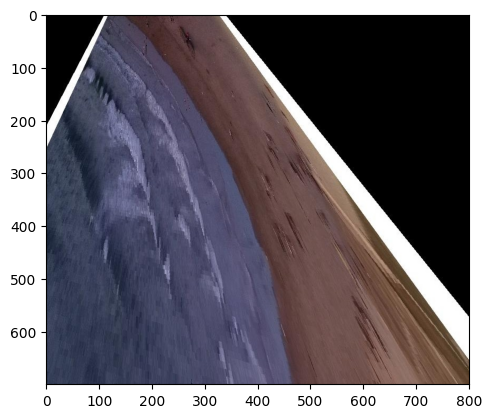

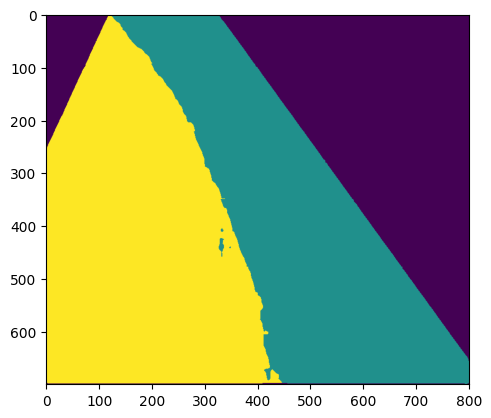

In [3]:
img_path = sorted(data['test']['images'])[85]
print(img_path)

pred = model.predict_patch(img_path, combination="max", patch_size = 256, stride = 128)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()

plt.imshow(pred)
plt.show()

# Save the results to an output folder

In [ ]:
# Data with 4 classes, to be able to compute the shoreline distance

data_path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/processed_4_classes"))

coast_data = CoastData(data_path)
split = coast_data.split_data()

data = DataLoaderManager.load_data(split)

In [ ]:
# Create a folders system to save the results
# SCLabels_prediction_by_set_unet
#   - images
#       - train
#       - validation
#       - test
#   - masks
#       - train
#       - validation
#       - test
#   - predicted_mask
#       - train
#       - validation
#       - test

# Create the folders
subfolders = ["images", "masks", "predicted_mask"]
subset = ["train", "validation", "test"]

path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/SCLabels_prediction_by_set_deeplab"))

os.makedirs(path, exist_ok=True)
for subfolder in subfolders:
    for s in subset:
        os.makedirs(os.path.join(path, subfolder, s), exist_ok=True)

In [ ]:
for split in data:
    print(f"Split: {split}")
    for img_path, mask_path in zip(data[split]["images"], data[split]["masks"]):
        pred = model.predict_patch(img_path, combination="max")
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Save the images
        img = cv2.imread(img_path)
        img_name = os.path.basename(img_path)
        mask_name = os.path.basename(mask_path)

        cv2.imwrite(os.path.join(path, "images", split, img_name), img)
        cv2.imwrite(os.path.join(path, "masks", split, mask_name), mask)
        cv2.imwrite(os.path.join(path, "predicted_mask", split, mask_name), pred.cpu().numpy())